In [1]:
import torchtext
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn.functional as F
from torchtext import data
from torch import nn
import random

import spacy
import math

import sys
sys.path.append('..')

from utils.load_data import GLOVE_PATH, LABEL_TO_INT

In [2]:
outpath = '/home/ndg/users/jkurre/mnli/models/bilstm.pt'

In [3]:
LABEL_TO_INT

{'contradiction': 1, 'entailment': 2, 'neutral': 3}

### Load Dataset

In [18]:
source = data.Field(
        tokenize = 'spacy'
        # , lower = True
        , batch_first = True
)

target = data.Field(
        sequential=False
        , use_vocab = False
        , is_target=True
)

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = '/home/ndg/users/jkurre/mnli/utils'
    , train = 'train_bow.csv' # test
    , validation = 'val_bow.csv' # test
    , test = 'test_bow.csv' # test
    , format = 'csv'
    , fields = {'sentence': ('text', source), 'gold_label': ('target', target)}
)

source.build_vocab(train_data, min_freq=2)
source.vocab.load_vectors(torchtext.vocab.Vectors(GLOVE_PATH, cache="."))

print(source.vocab.vectors.shape)
print(f"Unique tokens in text vocabulary: {len(source.vocab)}")

torch.Size([7495, 50])
Unique tokens in text vocabulary: 7495


### Build Model

In [19]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 4, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.reshape((1, hidden.shape[1], hidden.shape[2] * 2))
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        catted = torch.cat([hidden, encoder_outputs], 2)
        energy = F.relu(self.attn(catted))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]
    
class Seq2One(nn.Module):
    def __init__(self, input_size, output_size, embed_size,
                 hidden_size, n_layers, dropout):
        
        super(Seq2One, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.dropout = nn.Dropout(dropout)
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers, dropout=dropout, 
                            bidirectional=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(self.hidden_size * 2, output_size)
        
    def forward(self, x):
        # x: (seq_length, N) where N is the batch size
        embedded = self.dropout(self.embed(x.transpose(0,1)))
        # embedded: (seq_length, N, embed_size)
        outputs, (hidden, cell) = self.lstm(embedded)
        
        weights = self.attention(hidden[-2:], outputs)
        
        context = weights.bmm(outputs.transpose(0, 1))
        context = context.transpose(0, 1)
        
        context = context.squeeze(0)
        output = self.fc(context)
        output = F.log_softmax(output, dim=1)
        
        return output

In [20]:
"""Hyperparameters"""
# training
num_epochs = 20
learning_rate = 0.001
batch_size = 64

# model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(source.vocab)
output_size = len(LABEL_TO_INT)
embed_size = 50
hidden_size = 1024 # 2014 benchmark; slightly small
num_layers = 2 # benchmark did 4
dropout = 0.5

# define iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = batch_size,
     sort_within_batch = True,
     sort_key = lambda x: len(x.text), # minimize padding
     device = device)


model = Seq2One(input_size, output_size, embed_size, hidden_size,
                  num_layers, dropout).to(device)

pad_idx = source.vocab.stoi["<pad"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# simple cross entropy cost (might be numerically unstable if pred has 0)
# https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/6
def xentropy_cost(x_target, log_x_pred):
    """Cross Entropy for One Hot Encoded Targets"""
    assert x_target.size() == log_x_pred.size(), "size fail ! " + str(x_target.size()) + " " + str(log_x_pred.size())
    return -torch.sum(x_target * log_x_pred)

In [21]:
xloss_values = []
loss_values = []
running_loss = 0.0

for epoch in range(num_epochs):
    
    print(f"Epoch {epoch} of {num_epochs}")
    
    for batch_idx, batch in enumerate(train_iterator):
        input_data = batch.text.to(device)
        target_data = batch.target.to(device)
        target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))
        # index values of shape (*) returns tensor of shape (*, num_classes)
        # encoding position corresponds to labels; subtract tensor by 1
        
        output = model(input_data)
        
        optimizer.zero_grad()
        loss = xentropy_cost(target_data_one_hot, output)
        
        # if batch_idx % 10 == 9:
        #    print("XEntropy Loss:", round(loss.item(),2))
        
        # address gradient issue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        running_loss =+ loss.item() * batch_size
        xloss_values.append(loss.item())
    
    loss_values.append(running_loss)

Epoch 0 of 20
Epoch 1 of 20
Epoch 2 of 20
Epoch 3 of 20
Epoch 4 of 20
Epoch 5 of 20
Epoch 6 of 20
Epoch 7 of 20
Epoch 8 of 20
Epoch 9 of 20
Epoch 10 of 20
Epoch 11 of 20
Epoch 12 of 20
Epoch 13 of 20
Epoch 14 of 20
Epoch 15 of 20
Epoch 16 of 20
Epoch 17 of 20
Epoch 18 of 20
Epoch 19 of 20


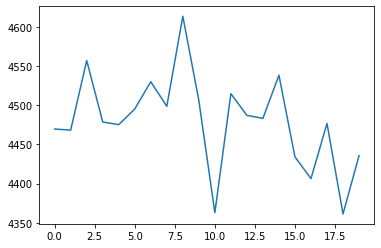

In [22]:
# bow experiment
plt.plot(loss_values)
plt.show()

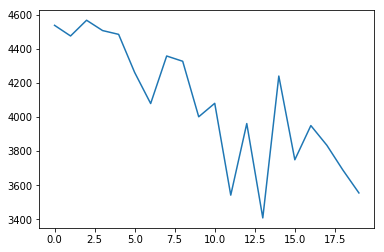

In [8]:
# bilstm with sentence separator token
plt.plot(loss_values)
plt.show()

In [10]:
torch.save(model, outpath)

/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Seq2One. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Load Model

In [11]:
model = torch.load(outpath)

In [12]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("---")
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
embed.weight 	 torch.Size([86080, 50])
lstm.weight_ih_l0 	 torch.Size([4096, 50])
lstm.weight_hh_l0 	 torch.Size([4096, 1024])
lstm.bias_ih_l0 	 torch.Size([4096])
lstm.bias_hh_l0 	 torch.Size([4096])
lstm.weight_ih_l0_reverse 	 torch.Size([4096, 50])
lstm.weight_hh_l0_reverse 	 torch.Size([4096, 1024])
lstm.bias_ih_l0_reverse 	 torch.Size([4096])
lstm.bias_hh_l0_reverse 	 torch.Size([4096])
lstm.weight_ih_l1 	 torch.Size([4096, 2048])
lstm.weight_hh_l1 	 torch.Size([4096, 1024])
lstm.bias_ih_l1 	 torch.Size([4096])
lstm.bias_hh_l1 	 torch.Size([4096])
lstm.weight_ih_l1_reverse 	 torch.Size([4096, 2048])
lstm.weight_hh_l1_reverse 	 torch.Size([4096, 1024])
lstm.bias_ih_l1_reverse 	 torch.Size([4096])
lstm.bias_hh_l1_reverse 	 torch.Size([4096])
attention.v 	 torch.Size([1024])
attention.attn.weight 	 torch.Size([1024, 4096])
attention.attn.bias 	 torch.Size([1024])
fc.weight 	 torch.Size([3, 2048])
fc.bias 	 torch.Size([3])
---
Optimizer's state_dict:
state 	 {13964

Mean accuracy: 61.43387862137862
Mean accuracy: 6.096104366442224


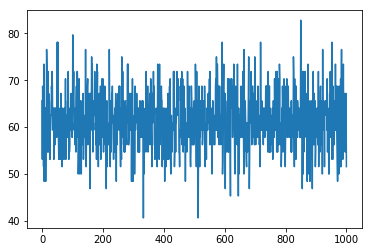

Mean accuracy: 58.71316183816184
Mean accuracy: 6.758186568495104


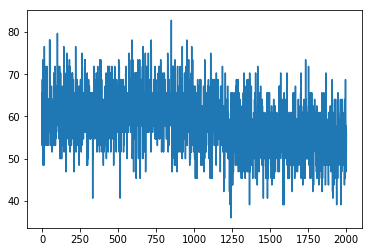

In [15]:
# bilstm with sentence separator token

all_acc = []

for iterator in [train_iterator, test_iterator]:
    for batch_idx, batch in enumerate(iterator):

        input_data = batch.text.to(device)
        target_data = batch.target.to(device)
        target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))

        output = model(input_data)

        max_output = torch.argmax(output, dim=1)
        actual_output = target_data_one_hot.argmax(dim=1)

        n_correct = (max_output == actual_output).sum()
        n_total = batch.batch_size
        test_acc = 100. * n_correct/n_total

        # print("test accuracy - %f" % test_acc)
        all_acc.append(test_acc.item())

        if batch_idx == 1000:
            break
    
    print(f"Mean accuracy: {np.mean(all_acc)}")
    print(f"Mean accuracy: {np.std(all_acc)}")
    plt.plot(all_acc)
    plt.show()

Mean accuracy: 42.6625122152349
Mean accuracy: 5.4928124467239945


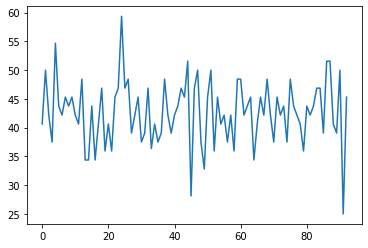

Mean accuracy: 40.159525717458415
Mean accuracy: 7.623960940591052


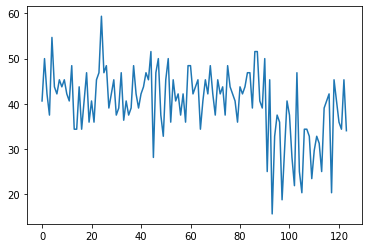

In [23]:
# bow experiment